# Annular square membrane deformation

We illustrate our implementation on a square annular membrane initially located in the $(Ox_1x_2)$ plane, embedded in $\mathbb{R}^3$. Its outer boundary of size $W_\text{out}=50$ mm is fixed whereas the inner boundary, of size $W_\text{in}=17.5$ mm, is subjected to an in-plane torsion of angle $90^\circ$ and to an out-of-plane vertical displacement of amplitude $t W_\text{out}/2$ for $t=0$ to $t=1$. Note that a similar example has been investigated in [[ROO05](#References)] with a Neo-Hookean model whereas we use here $\alpha=3.5$.

<p align="center">
<img src="annular_square_membrane.gif" width=400>
</p>

The mesh is obtained from `Gmsh` and we use the `fenis_optim.mesh_utils.import_msh` utility function to load the corresponding `.msh` file and retrieve the corresponding mesh, cell and facet domains.

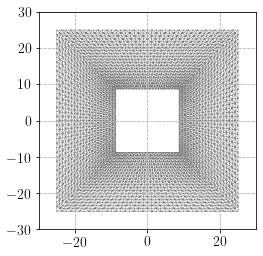

In [1]:
from ufl import grad, as_matrix, Identity
from dolfin import (
    Function,
    FunctionSpace,
    VectorFunctionSpace,
    TensorFunctionSpace,
    DirichletBC,
    Constant,
    project,
    Expression,
    plot,
    XDMFFile,
)
import numpy as np
from fenics_optim import (
    MosekProblem,
    to_mat,
)
from fenics_optim.mesh_utils import import_msh
from ogden_membrane import OgdenMembrane

Wout = 50
Wint = 17.5
Umax = Wout / 2

mu = Constant(1.0)
alpha = Constant(3.5)

mesh, domains, facets = import_msh("annular_square.msh")

plot(mesh, linewidth=0.5);

We then define the imposed displacement expression and apply the corresponding boundary conditions. We use here a linear interpolation for the displacement field. Depending whether $\sigma_1, \sigma_2 > \epsilon$ (*taut*), $\sigma_1 > \epsilon, \sigma_2\approx 0$ (*wrinkling*) or $\sigma_1\approx\sigma_2\approx 0$ (*slack*), we determine the status of the membrane. We use below $\epsilon = 10^{-2}\max\{1,\|\sigma\|_\infty\}$

In [2]:
# s*90° rotation and vertical displacement
Uimp = Expression(
    ("cos(t)*x[0]+sin(t)*x[1]-x[0]", 
     "-sin(t)*x[0]+cos(t)*x[1]-x[1]", 
     "Umax*t"),
    t=0,
    Umax=Umax,
    degree=1,
)

V = VectorFunctionSpace(mesh, "CG", degree=1, dim=3)

bc = [
    DirichletBC(V, Constant((0.0, 0.0, 0.0)), facets, 1),
    DirichletBC(V, Uimp, facets, 2),
]

We then define the corresponding optimization problem and specify the initial metric for the embedded surface. The Cauchy stress is then recovered from the solution and principal stresses and directions are computed. 

In [3]:
out_file = XDMFFile("annular_square.xdmf")
out_file.parameters["functions_share_mesh"] = True
out_file.parameters["flush_output"] = True
for theta in np.linspace(0, np.pi / 2, 10)[1:]:
    print("Torsion angle: {:.0f}°".format(theta*180/np.pi))
    Uimp.t = theta
    prob = MosekProblem("No-compression membrane model")
    u = prob.add_var(V, bc=bc, name="Displacement")

    G = grad(u)
    metric = as_matrix([[1, 0], [0, 1], [0, 0]])
    energy = OgdenMembrane(G, mu, alpha, metric, degree=1)
    prob.add_convex_term(energy)

    prob.parameters["log_level"] = 0
    prob.optimize()

    out_file.write(u, theta)

    t = prob.get_var("t")
    s = prob.get_var("s")

    # recover principal stretches from t and s
    V0 = FunctionSpace(mesh, "DG", 0)
    Vv0 = VectorFunctionSpace(mesh, "DG", 0, dim=2)
    lambda1 = project(
        (t + s[0]) ** 0.5,
        V0,
        form_compiler_parameters={"quadrature_degree": energy.degree},
    )
    lambda1.rename("lambda_1", "")
    lambda2 = project(
        (t - s[0]) ** 0.5,
        V0,
        form_compiler_parameters={"quadrature_degree": energy.degree},
    )
    lambda2.rename("lambda_2", "")

    out_file.write(lambda1, theta)
    out_file.write(lambda2, theta)

    sig1 = Function(V0, name="sigma_1")
    sig2 = Function(V0, name="sigma_2")
    eig1 = Function(Vv0, name="Eigendirection 1")
    eig2 = Function(Vv0, name="Eigendirection 2")

    # recover stress from Lagrange multiplier
    S = -2 * to_mat(prob.get_lagrange_multiplier("Stress"))
    F = Identity(2) + as_matrix([[u[i].dx(j) for j in range(2)] for i in range(2)])
    VS = TensorFunctionSpace(mesh, "DG", 0, shape=(2, 2))
    sigma = project(
        F * as_matrix([[S[0, 0], 1 / 2 * S[0, 1]], [1 / 2 * S[1, 0], S[1, 1]]]) * F.T,
        VS,
        form_compiler_parameters={"quadrature_degree": energy.degree},
    )
    sigma.rename("Cauchy stress", "")
    data1 = sig1.vector().get_local()
    data2 = sig2.vector().get_local()
    data_eig1 = eig1.vector().get_local()
    data_eig2 = eig2.vector().get_local()
    for e in range(V0.dim()):
        sig_i, eig_i = np.linalg.eig(
            sigma.vector()[4 * e : 4 * (e + 1)].reshape((2, 2))
        )
        if sig_i[0] < sig_i[1]:
            i1, i2 = 1, 0
        else:
            i1, i2 = 0, 1
        data_eig1[2 * e : 2 * (e + 1)] = sig_i[i1] * eig_i[:, i1]
        data_eig2[2 * e : 2 * (e + 1)] = sig_i[i2] * eig_i[:, i2]
        data1[e] = sig_i[i1]
        data2[e] = sig_i[i2]
    eig1.vector().set_local(data_eig1)
    eig2.vector().set_local(data_eig2)
    sig1.vector().set_local(data1)
    sig2.vector().set_local(data2)

    # Determine taut (0), wrinkling (1) or slack (2) status
    status = Function(V0, name="status")
    tol = 1e-2
    slack = np.logical_and(
        data1 / max(1, max(data1)) < tol, data2 / max(1, max(data2)) < tol, dtype=float
    )
    wrinkling = np.logical_or(
        data1 / max(1, max(data1)) < tol, data2 / max(1, max(data2)) < tol, dtype=float
    )
    if theta > 0:
        status.vector().set_local(np.maximum(2 * slack, wrinkling))

    out_file.write(sig1, theta)
    out_file.write(sig2, theta)
    out_file.write(eig1, theta)
    out_file.write(eig2, theta)
    out_file.write(sigma, theta)
    out_file.write(status, theta)

Torsion angle: 10°
Torsion angle: 20°
Torsion angle: 30°
Torsion angle: 40°
Torsion angle: 50°
Torsion angle: 60°
Torsion angle: 70°
Torsion angle: 80°
Torsion angle: 90°


## References

[ROO15] de Rooij, R., & Abdalla, M. M. (2015). A finite element interior-point implementation of tension field theory. Computers & Structures, 151, 30-41.